### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [1]:
from IPython.display import Image
%matplotlib inline

# experimental script
import pickle
import forest_surveyor.datasets as ds
from forest_surveyor.routines import experiment

LOADING NEW DATA SET.

in encoder
Finding best parameters for Random Forest. Checking for prior tuning parameters.

Using existing params file. To re-tune, delete file at whiteboxing\accident_small_samp_pickles\params.json

Best OOB Cohen's Kappa during tuning: 0.8633
Best parameters: {'min_samples_leaf': 1, 'n_estimators': 1500, 'max_depth': 16}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.7659
Cohen's Kappa on unseen instances: -0.0049

Precision: [0.0, 0.77]
Recall: [0.0, 1.0]
F1 Score: [0.0, 0.87]
Support: [95, 315]

Confusion matrix, without normalization
[[  0  95]
 [  1 314]]


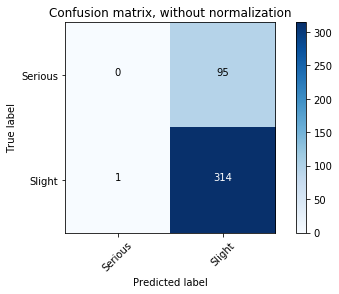

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


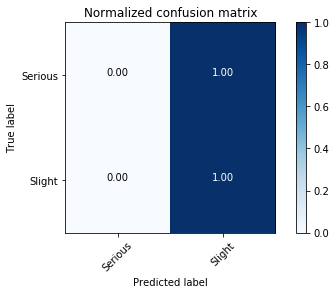

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Fri May  4 00:26:31 2018 with batch_size = 8 and n_batches = 50...(please wait)


In [ ]:
alpha_scores = 0.75
for dataset in [
                ds.accident_small_samp_data,
                ds.adult_small_samp_data,
                ds.bankmark_samp_data,
                ds.car_data,
                ds.cardiotography_data,
                ds.credit_data,
                ds.german_data,
                ds.lending_tiny_samp_data,
                ds.nursery_samp_data,
                ds.rcdv_samp_data
               ]:

# for dataset in [ds.rcdv_samp_data]:
    rule_acc, results, output_df = experiment(dataset,
                    n_instances=500,
                    n_batches=50,
                    support_paths=0.05,
                    alpha_paths=0.6,
                    alpha_scores=alpha_scores,
                    which_trees='majority',
                    eval_model=True,
                    run_anchors=True
                        )

# LIME

In [12]:
import numpy as np
mydata=dataset()
tt = mydata.tt_split()

np.random.seed(mydata.random_state)

explainer = limtab.LimeTabularExplainer(training_data=np.array(tt['X_train'].todense())
                                        , feature_names=mydata.onehot_features
                                        , training_labels=['y_train']
                                        , class_names=mydata.class_names
                                        , categorical_features=mydata.categorical_features
                                        , categorical_names=mydata.onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

if tt['encoder'] is None:
    instance = tt['X_test'][0:1]
else:
    instance = tt['encoder'].transform(tt['X_test'][0:1]).todense()

# exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
exp = explainer.explain_instance(np.array(instance)[0]
                                 , enc_model.predict_proba
                                 , top_labels=4)

C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


NameError: name 'rf' is not defined

# Part 1. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [ ]:
from forest_surveyor.plotting import rule_profile_plots
i = 4
alpha_scores = 0.75
rule_profile_plots(rule_acc[i], ds.rcdv_samp_data().class_names, ig=False, cp=True, alpha_scores=alpha_scores)

[results[i][ra].pruned_rule for ra in range(6)]
[results[r][ra].pruned_rule for r in range(len(results)) for ra in range(3)]

# Part 2. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [ ]:
# run the full forest survey
tt_correct_stats, tt_incorrect_stats = cor_incor_forest_survey(
 f_walker = f_walker, X=tt['X_test'], y=tt['y_test'])

In [ ]:
plot_mean_path_lengths(forest_stats=tt_correct_stats, class_names=mydata.class_names)
plot_mean_path_lengths(forest_stats=tt_incorrect_stats, class_names=mydata.class_names)

In [ ]:
plot_varimp(rf, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_root_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_child_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_lower_traversals', mydata.class_names, mydata.onehot_features)

In [ ]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = mydata.onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = mydata.onehot_features
)

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [ ]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()